# Null Imputation and Data Pre-processing

Data exploration and analysis for the purpose of pre-processing, null imputation and feature engineering. This workbook's purpose is to output seperate datasets train/test and validation datasets, for modelling (notebook 04) and a seperate set for insight oriented analysis (notebook 03).

In [102]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import modelling as ml
from visualisations import compare_histograms
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split


# set random seed for reproducibility
np.random.seed(42)

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [103]:
# df_val = pd.read_csv('../data/validation_set.csv')
# df_val.set_index('name', inplace=True)
df = pd.read_csv('../data/clean_combined_wines.csv')
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino,age,log_price,log_rating_qty
name,,,,,,,,,,,,,,,
Matchbook Red Gravel Cabernet Sauvignon 2020,Other,United States,2020,Matchbook,red,Cabernet Sauvignon,13.96,4.0,26,13.9,WW,False,4,2.636196,3.258097
Paternoster Synthesi 2015,Aglianico Del Vulture,Italy,2015,Paternoster,sparkling,Unknown,11.83,3.7,50,NaN,unknown,True,9,2.470639,3.912023
Sextant Central Coast Zinfandel 2018,Central Coast,United States,2018,Sextant,red,Zinfandel,21.00,3.8,152,NaN,unknown,True,6,3.044522,5.023881
Bertin Fils Clos Lhermitage Lalande De Pomerol 2014,Lalandedepomerol,France,2014,Bertin Fils,red,Pomerol,20.93,3.9,42,NaN,unknown,True,10,3.041184,3.737670
Vina Pedrosa Crianza Ribera Del Duero 2014,Ribera Del Duero,Spain,2014,Vina Pedrosa,rose,Unknown,26.80,4.0,2518,NaN,unknown,True,10,3.288402,7.831220


In [104]:
# Add a column for age
df['age'] = df['vintage'].apply(lambda x: 2024 - int(x))
# df_val['age'] = df_val['vintage'].apply(lambda x: 2024 - int(x))

In [105]:
df.describe()

,vintage,price,rating,rating_qty,abv,age,log_price,log_rating_qty
count,43328.000000,43328.000000,43328.000000,43328.000000,849.000000,43328.000000,43328.000000,43328.000000
mean,2015.439623,35.542472,3.860910,421.965196,13.779918,8.560377,3.053594,5.142490
std,3.226675,77.481078,0.306019,927.224776,1.040474,3.226675,0.848266,1.249650
min,1984.000000,2.800000,2.500000,21.000000,5.000000,3.000000,1.029619,3.044522
25%,2014.000000,11.490000,3.700000,62.000000,13.500000,7.000000,2.441477,4.127134
50%,2016.000000,18.510000,3.800000,151.000000,14.000000,8.000000,2.918311,5.017280
75%,2017.000000,31.150000,4.100000,395.000000,14.500000,10.000000,3.438814,5.978886
max,2021.000000,3700.660000,5.000000,24713.000000,16.000000,40.000000,8.216266,10.115085


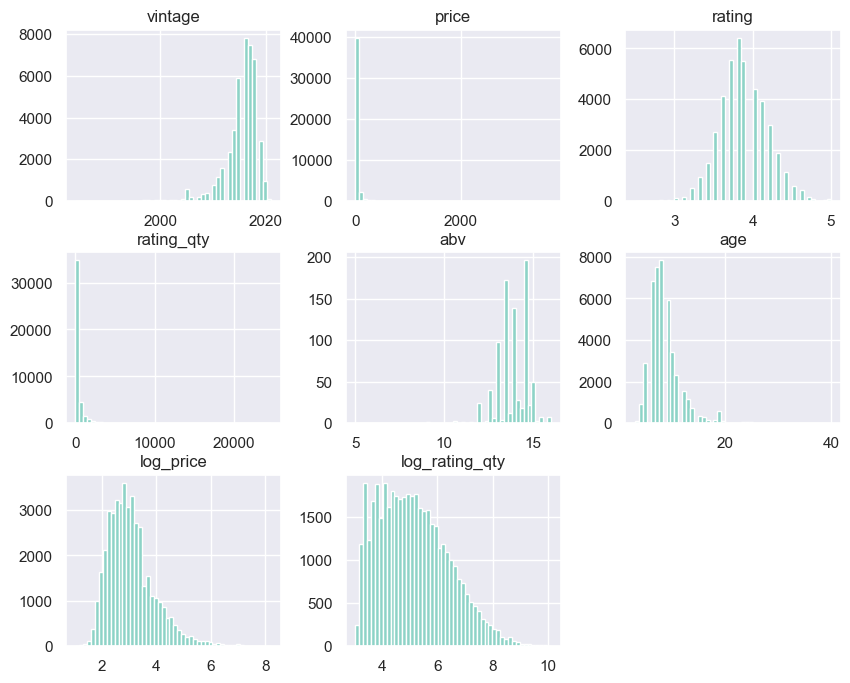

In [106]:
df.hist(bins=50, figsize=(10, 8));

* Vintage skewed left centred around a median 2016. Age the reverse, median age of 8 years (as of 2024). 
* Price and rating quantity both could benefit from logarithmic transformation for the benefit of modelling. 
* Rating quantity, likely many zero values, a minimum limit will be set for rating_qty so that ratings can be considered reliable. 
* Rating median 3.8 and mean 3.11, mean likely being skewed due to those wines with 0 ratings having a rating of 0 currently in the dataset.
[Futher analysis of distributions, post-transformation can be seen in the following notebook]

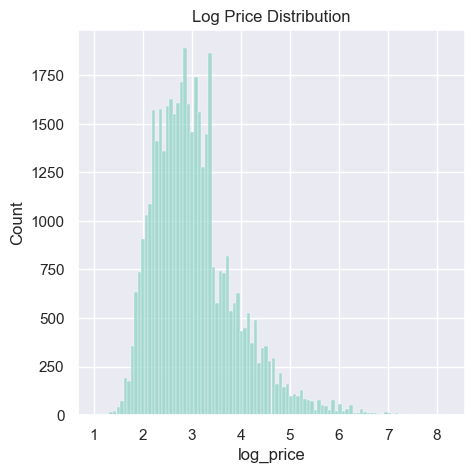

In [107]:
# log transform price and plot
df['log_price'] = np.log(df['price'])
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution')
sns.histplot(df['log_price'], bins=100)  # kde=False turns off the kernel density estimate plot overlay
plt.show();

* Log price much more normally distributed. 

Max outlier bound log_price: 4.935
Number of remaining rows: 41898, rows removed: 1430


<Axes: title={'center': 'Log Price Distribution - Outliers Removed via IQR'}, xlabel='log_price', ylabel='Count'>

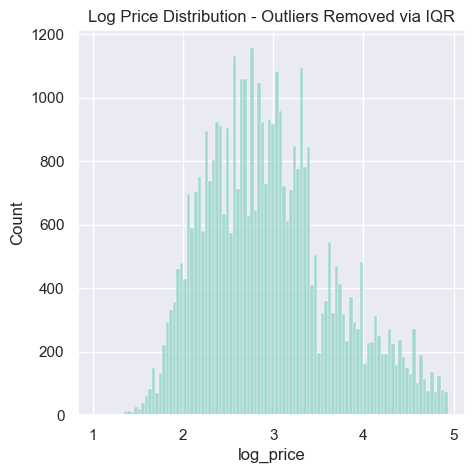

In [108]:
# calculate interquartile range of price, and set a limit at 1.5 IQR above 75% percentile
Qrt1 = np.quantile(df['log_price'], 0.25)
Qrt3 = np.quantile(df['log_price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
df_IQR_price = df[df['log_price'] < outlier_price_limit]
print('Max outlier bound log_price: ', round(outlier_price_limit,3), sep='')
print(f'Number of remaining rows: {df_IQR_price.shape[0]}, rows removed: {df.shape[0] - df_IQR_price.shape[0]}')
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution - Outliers Removed via IQR')
sns.histplot(df_IQR_price['log_price'], bins=100)

In [109]:
df['log_price'].describe()

count    43328.000000
mean         3.053594
std          0.848266
min          1.029619
25%          2.441477
50%          2.918311
75%          3.438814
max          8.216266
Name: log_price, dtype: float64

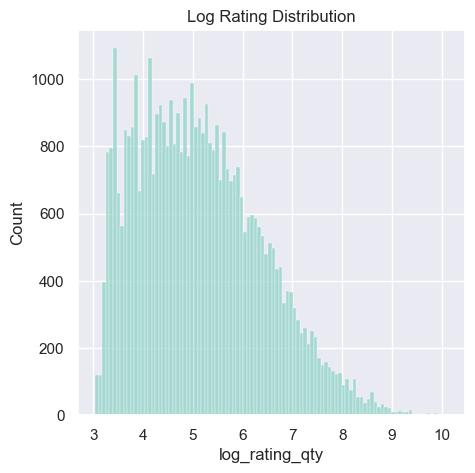

In [110]:
# log transform price and plot
df['log_rating_qty'] = np.log(df['rating_qty'])
plt.figure(figsize=(5, 5))
plt.title('Log Rating Distribution')
sns.histplot(df['log_rating_qty'], bins=100);

* More normally distributed which will be better suited to a linear regression model and perhaps to feature engineering. 
* One of the data scrapes in our original data set had a cut off for minimum number of reviews. Hence the sharp drop in log rating_qty at around 3.5. We will consider limiting modelled data to only those with a minimum number of reviews for reliability of reviews.  

In [111]:
# There are 8980 wines with 0 ratings, 10836 with less than 20. We will drop all with less than 20. 
df = df[df['rating_qty'] >20]
# df_val = df_val[df_val['rating_qty'] >20]

In [112]:
# # Transform validaiton dataset
# df_val['log_price'] = np.log(df_val['price'])
# df_val['log_rating_qty'] = np.log(df_val['rating_qty'])
# print(df.shape)
# print(df_val.shape)

## Reduce Categories 

In [113]:
# Reduce the number of regions in df
print('Prior Length:', df['region'].value_counts().shape[0])
region_value_counts = df['region'].value_counts()
remove_regions = region_value_counts[region_value_counts < 31]
df['region'] = df['region'].apply(lambda x: 'Other' if x in remove_regions.index else x)
print('Post Length:', df['region'].value_counts().shape[0])

Prior Length: 258
Post Length: 242


In [114]:
# Reduce the number of countries in df
print('Prior Length:', df['country'].value_counts().shape[0])
country_value_counts = df['country'].value_counts()
remove_country = country_value_counts[country_value_counts < 31]
df['country'] = df['country'].apply(lambda x: 'Other' if x in remove_country.index else x)
print('Post Length:', df['country'].value_counts().shape[0])

Prior Length: 24
Post Length: 22


In [115]:
# # Match regions in val
# print('Val region prior length:', df_val['region'].value_counts().shape[0])
# df_val['region'] = df_val['region'].apply(lambda x: 'Other' if x in remove_regions.index else x)
# print('Val post length:', df_val['region'].value_counts().shape[0])
# # Match countries in val
# print('Prior country length:', df_val['country'].value_counts().shape[0])
# df_val['country'] = df_val['country'].apply(lambda x: 'Other' if x in remove_country.index else x)
# print('Post country length:', df_val['country'].value_counts().shape[0])

In [116]:
# val_cnt = list(df_val['region'].unique())
# df_cnt = list(df['region'].unique())
# np.setdiff1d(val_cnt, df_cnt)

# Modelling Datasets

### Imputing ABV -  Iterative Imputer

In [117]:
print(f'ABV nulls: {(df["abv"].isna().sum())}')

ABV nulls: 42479


**With all categories label encoded**

In [118]:
# df_encoded = df.copy()
# df_val_encoded = df_val.copy()
# columns_to_encode = ['region', 'country', 'vintage', 'wine_variety', 'grape_variety', 'from_vivino', 'producer']

# le = LabelEncoder()

# # Fit and stransform train/test dataset 
# for column in columns_to_encode:
#     df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))

# # Transform validation dataset using the fitted label encoder
# # Add 'unknown' to the encoder's classes
# le.classes_ = np.append(le.classes_, 'unknown')
    
# for column in columns_to_encode:
#     df_val_encoded[column] = df_val_encoded[column].apply(lambda x: x if x in le.classes_ else 'unknown')
#     df_val_encoded[column] = le.transform(df_val_encoded[column].astype(str))

In [119]:
df_encoded = df.copy()
# df_val_encoded = df_val.copy()
columns_to_encode = ['region', 'country', 'vintage', 'wine_variety', 'grape_variety', 'from_vivino', 'producer']

# Store the label encoders for each column in a dictionary
le_dict = {}

# Fit and transform the training dataset, and transform the validation dataset
for column in columns_to_encode:
    le = LabelEncoder()
    # Fit on the training data
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    
    # Store the fitted LabelEncoder for this column
    le_dict[column] = le
    

    # valid_labels = df_val_encoded[column].map(lambda x: x if x in le.classes_ else 'unknown').astype(str)
    # # Temporarily add 'unknown' to classes_ if not already present
    # if 'unknown' not in le.classes_:
    #     le.classes_ = np.append(le.classes_, 'unknown')
    # df_val_encoded[column] = le.transform(valid_labels)

In [120]:
# df_val.describe()

In [121]:
df.describe()

,vintage,price,rating,rating_qty,abv,age,log_price,log_rating_qty
count,43328.000000,43328.000000,43328.000000,43328.000000,849.000000,43328.000000,43328.000000,43328.000000
mean,2015.439623,35.542472,3.860910,421.965196,13.779918,8.560377,3.053594,5.142490
std,3.226675,77.481078,0.306019,927.224776,1.040474,3.226675,0.848266,1.249650
min,1984.000000,2.800000,2.500000,21.000000,5.000000,3.000000,1.029619,3.044522
25%,2014.000000,11.490000,3.700000,62.000000,13.500000,7.000000,2.441477,4.127134
50%,2016.000000,18.510000,3.800000,151.000000,14.000000,8.000000,2.918311,5.017280
75%,2017.000000,31.150000,4.100000,395.000000,14.500000,10.000000,3.438814,5.978886
max,2021.000000,3700.660000,5.000000,24713.000000,16.000000,40.000000,8.216266,10.115085


In [122]:
# Impute missing abv values on train/test df 
it_imp = IterativeImputer(estimator=LinearRegression(), 
                           max_iter=5)
imputed_data = it_imp.fit_transform(df_encoded.drop(columns = ['reviewed_by']))
imputed_data = pd.DataFrame(imputed_data, columns=df.drop(columns = ['reviewed_by']).columns)

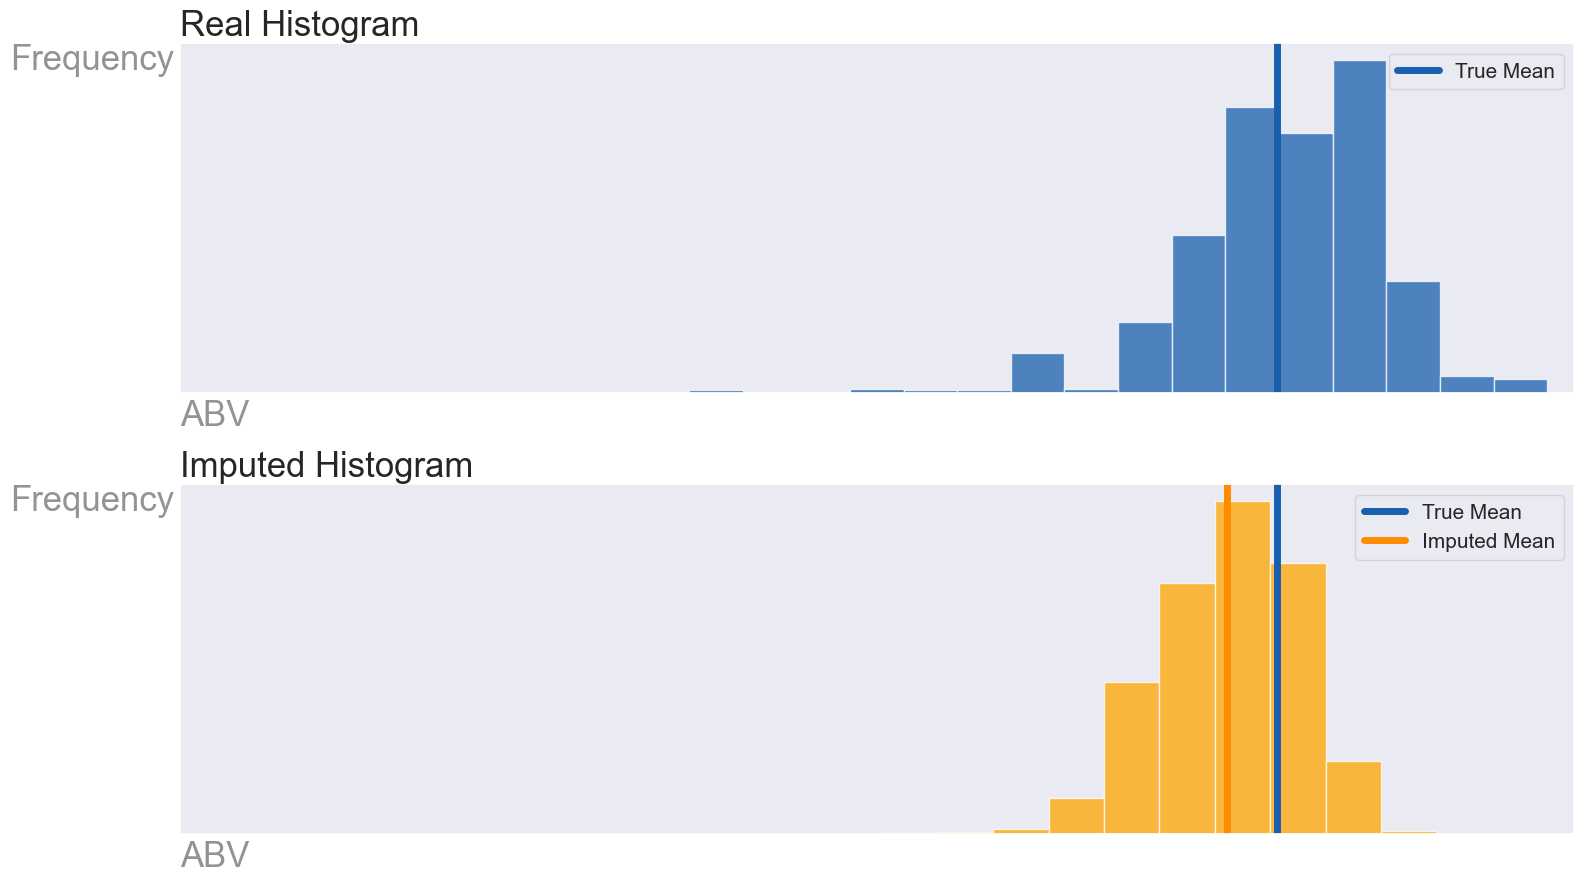

In [123]:
compare_histograms(imputed_column = imputed_data['abv'],
                   original_column = df['abv'],
                   x_label = 'ABV',
                   y_label = 'Frequency', bins = 25)

In [124]:
# Try with decision tree classifier 
it_imp_rf = IterativeImputer(estimator=DecisionTreeRegressor(), 
                           max_iter=5)
imputed_data_rf = it_imp_rf.fit_transform(df_encoded.drop(columns = ['reviewed_by']))
imputed_data_rf = pd.DataFrame(imputed_data_rf, columns=df_encoded.drop(columns = ['reviewed_by']).columns)

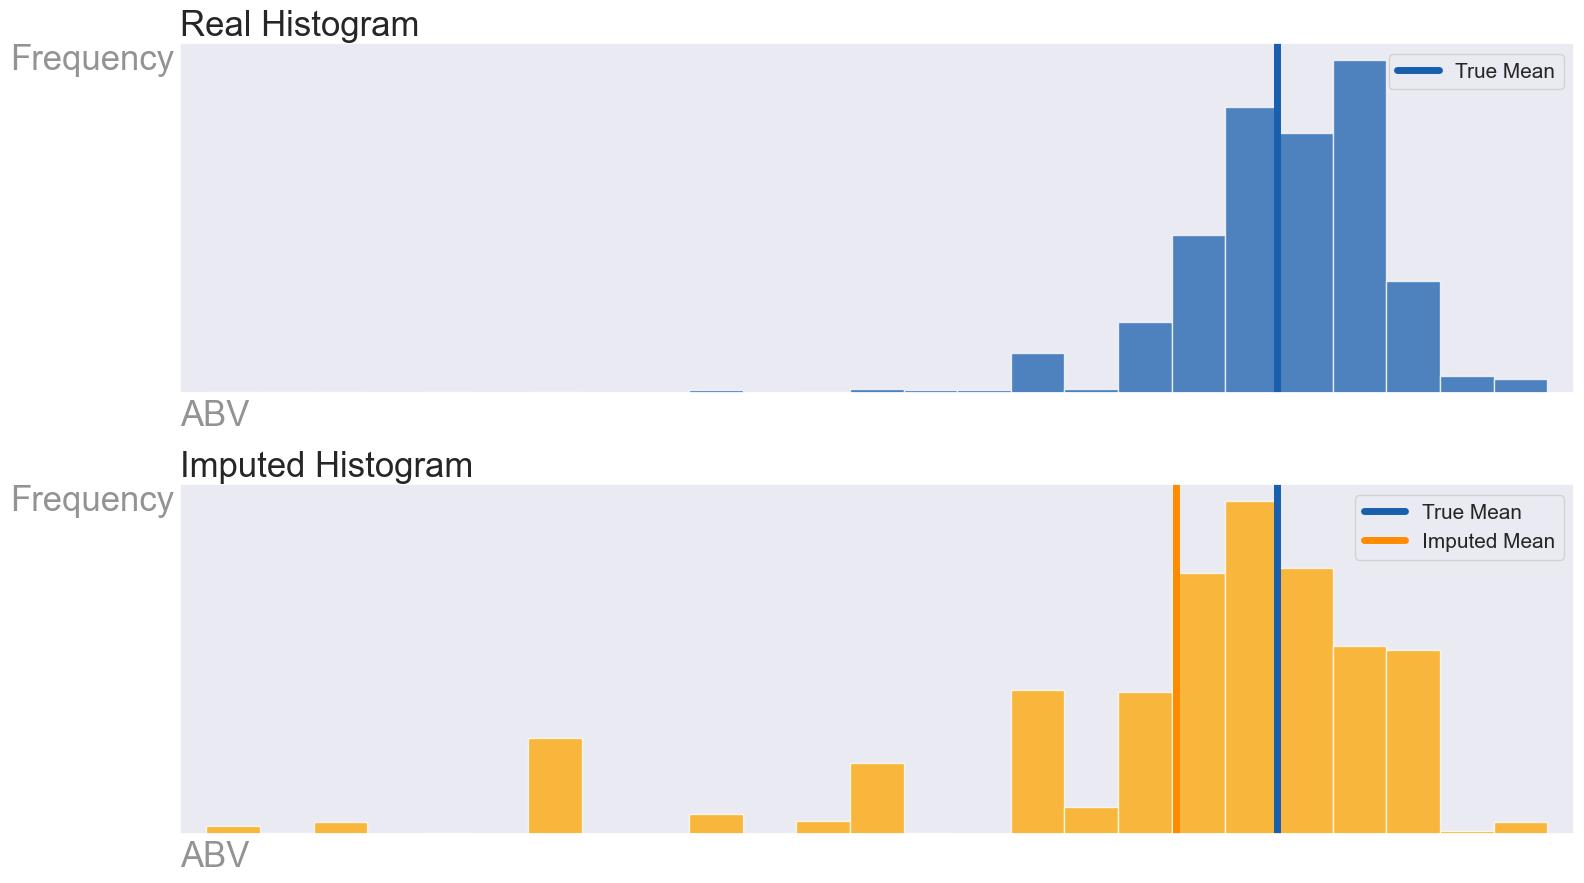

In [125]:
compare_histograms(imputed_column = imputed_data_rf['abv'],
                   original_column = df['abv'],
                   x_label = 'ABV',
                   y_label = 'Frequency', bins = 25)

The linear regression imputation is better at maintaining the mean of the distrbution and although it reduces the spread of the ABV distribution it matches the over all shape with less outliers than decision trees. 

In [126]:
# # Apply linear regression imputation on validation dataset
# df_val_imputed = it_imp.transform(df_val_encoded.drop(columns = ['reviewed_by']))
# # df_val_imputed = pd.DataFrame(df_val_imputed, columns=df.drop(columns = ['reviewed_by']).columns)

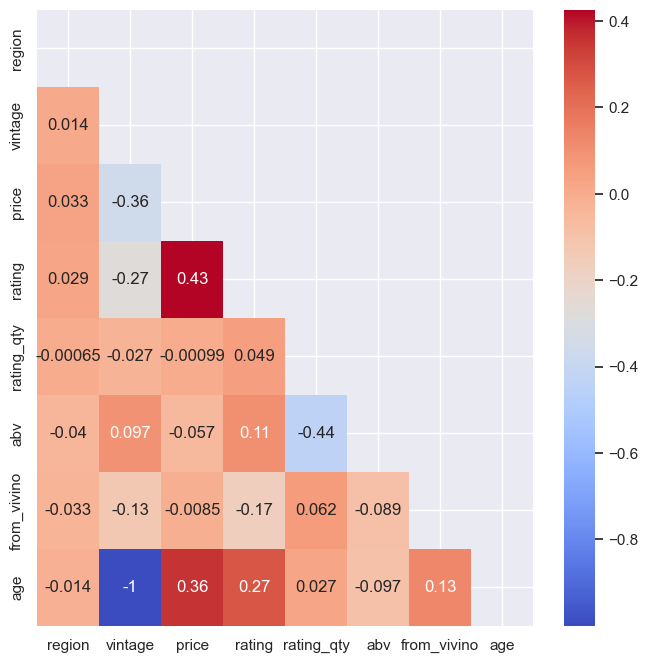

In [127]:
# checking correlation in data with label encoded features
numeric = imputed_data.drop(columns = ['country', 'wine_variety', 'grape_variety', 'producer', 'log_price', 'log_rating_qty'])

plt.figure(figsize=(8, 8))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='coolwarm');

* As should be expected the encoded categorical variables have little to no correlation with price, rating and other continuous variables. 

## Additional Feature Engineering
On modelling datasets for purposes of improved model accuracy. 

In [128]:
imputed_data['age^2'] = imputed_data['age'] ** 2
# df_val_imputed['age^2'] = df_val_imputed['age'] ** 2

In [129]:
imputed_data['rating * log_rating_qty'] = imputed_data['rating'] * imputed_data['log_rating_qty']
# df_val_imputed['rating * log_rating_qty'] = df_val_imputed['rating'] * df_val_imputed['log_rating_qty']

In [130]:
# Put name index on inputed set 
imputed_data.index = df.index

In [131]:
df_train_test_imputed, df_validation_imputed = train_test_split(imputed_data, test_size=0.1, random_state=42)
print(df_train_test_imputed.shape)
print(df_validation_imputed.shape)

(38995, 16)
(4333, 16)


In [132]:
df_tt_eda, df_val_eda = train_test_split(df, test_size=0.1, random_state=42)
print(df_tt_eda.shape)
print(df_val_eda.shape)

(38995, 15)
(4333, 15)


In [133]:
print(df_tt_eda.index)
print(df_train_test_imputed.index)

Index(['Ruffino Il Leo Chianti Superiore 2017',
       'Darenberg The Love Grass Shiraz 2017', 'Pittnauer Pitti 2018',
       'Darenberg The Footbolt Shiraz 2017',
       'Kendalljackson Vintners Reserve Cabernet Sauvignon 2018',
       'Robert Mondavi Private Selection Cabernet Sauvignon 2019',
       'Haras De Pirque Reserva De Propiedad 2016',
       'Pagos De Araiz Crianza 2016', 'Muruve Crianza 2014',
       'Chateau Langoa Barton Saintjulien Grand Cru Classe 2001',
       ...
       'Mandrarossa Syrah Desertico 2018',
       'Tedeschi Marne 180 Amarone Della Valpolicella 2015',
       'Bibi Graetz Testamatta Toscana 2016', 'Punt Road Pinot Noir 2020',
       'Chateau Gruaud Larose Saintjulien Grand Cru Classe 2016',
       'Feudi Di San Gregorio Lacryma Christi Rosso 2010',
       'Orowines Bluegray 2019', 'El Casetero Garnacha 2017',
       'Lidl Teroldego Rotaliano Superiore Riserva 2012',
       'Infinitus Tempranillo 2016'],
      dtype='object', name='name', length=38995)
In

In [135]:
# Export pre-processed Train and Test datasets
# For EDA (workbook 03):
df_tt_eda.to_csv('../data/clean_combined_wines.csv', index=True)

# For modelling (workbook 04):
# imputed_data.set_index(df.index, inplace=True)
df_train_test_imputed.to_csv('../data/modelling_wines.csv', index=True)


# Export validation datasets for use in validation and app: 
# For modelling (workbook 05):
# df_val_eda .set_index(df_val.index, inplace=True)
df_val_eda.to_csv('../data/validation_frontend.csv', index=True)

# For modelling (workbook 05):
# df_val_imputed.set_index(df_val.index, inplace=True)
df_validation_imputed.to_csv('../data/validation_modelling.csv', index=True)